# Etude des offres d'emplois

In [1]:
import re
import pandas as pd 
import string
from collections import defaultdict
from datetime import datetime
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer # ou CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/octopize/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Ouverture du fichier de données

In [2]:
df = pd.read_excel('20231026-Donnees_Info_Poste.xlsx') 
df

,titre,entreprise,lieu,categorie,contrat,salaire,parution,description,note,review
0,Data Entry Clerk,Charles Hull Contracting Co P/L,"Waroona, Mandurah & Peel WA",Data Entry & Word Processing (Administration &...,Full time,"$60,000 – $70,000 per year",Posted 1d ago,Charles Hull Contracting is a long-established...,NaN,NaN
1,Data Entry Administrator,Fienza,"Brendale, Brisbane QLD",Data Entry & Word Processing (Administration &...,Full time,NaN,Posted 2d ago,"About usFienza develops, manufactures, and dis...",NaN,NaN
2,Junior Data Analyst,Add Staff Recruitment Pty Ltd,"Fortitude Valley, Brisbane QLD",Business/Systems Analysts (Information & Commu...,Full time,"$55,000 – $60,000 per year",Posted 3d ago,Solar Service Guys (SSG) is a National Special...,NaN,NaN
3,Data Science Cadet,Jemena,Melbourne VIC,"Mathematics, Statistics & Information Sciences...",Contract/Temp,NaN,Posted 17h ago,About UsJemena is an Australian energy company...,3.0,/companies/jemena-432985/reviews?jobId=71046255
4,"Head of Data Strategy, Analytics & Insights",AustralianSuper,Melbourne VIC,Other (Consulting & Strategy),Full time,NaN,Posted 2d ago,AustralianSuper is on an exciting transformati...,4.0,/companies/australiansuper-813334/reviews?jobI...
...,...,...,...,...,...,...,...,...,...,...
149,Data Analyst,Windsor Group,"Milton, Brisbane QLD",Business/Systems Analysts (Information & Commu...,Contract/Temp,NaN,Posted 7d ago,Assist your community in during times of crisi...,NaN,NaN
150,Data Analyst,Clarrow Pty Ltd,Melbourne VIC,Business/Systems Analysts (Information & Commu...,Full time,NaN,Posted 6d ago,As a Data Analyst you will play a critical rol...,NaN,NaN
151,Data Analyst/Engineer,DSi Professionals Pty Ltd,Canberra ACT,Business/Systems Analysts (Information & Commu...,Contract/Temp,NaN,Posted 10h ago,We are a Professional Services Consulting busi...,NaN,NaN
152,Billing and Meter data Analyst - Retail Energy,Next Business Energy Pty Ltd,"Southbank, Melbourne VIC","Analysis & Reporting (Mining, Resources & Energy)",Full time,NaN,Posted 3d ago,About The BusinessNext Business Energy is a gr...,NaN,NaN


Colonne Parution traitement - extraction du temps

In [3]:
def extraction_temps(parution):
    pattern = r'(\d+[dh])'  # Correspond à un nombre suivi de "d" ou "h"
    temps = re.findall(pattern, parution)[0]
    return temps

df['parution_modif'] = df['parution'].apply(extraction_temps)
df

,titre,entreprise,lieu,categorie,contrat,salaire,parution,description,note,review,parution_modif
0,Data Entry Clerk,Charles Hull Contracting Co P/L,"Waroona, Mandurah & Peel WA",Data Entry & Word Processing (Administration &...,Full time,"$60,000 – $70,000 per year",Posted 1d ago,Charles Hull Contracting is a long-established...,NaN,NaN,1d
1,Data Entry Administrator,Fienza,"Brendale, Brisbane QLD",Data Entry & Word Processing (Administration &...,Full time,NaN,Posted 2d ago,"About usFienza develops, manufactures, and dis...",NaN,NaN,2d
2,Junior Data Analyst,Add Staff Recruitment Pty Ltd,"Fortitude Valley, Brisbane QLD",Business/Systems Analysts (Information & Commu...,Full time,"$55,000 – $60,000 per year",Posted 3d ago,Solar Service Guys (SSG) is a National Special...,NaN,NaN,3d
3,Data Science Cadet,Jemena,Melbourne VIC,"Mathematics, Statistics & Information Sciences...",Contract/Temp,NaN,Posted 17h ago,About UsJemena is an Australian energy company...,3.0,/companies/jemena-432985/reviews?jobId=71046255,17h
4,"Head of Data Strategy, Analytics & Insights",AustralianSuper,Melbourne VIC,Other (Consulting & Strategy),Full time,NaN,Posted 2d ago,AustralianSuper is on an exciting transformati...,4.0,/companies/australiansuper-813334/reviews?jobI...,2d
...,...,...,...,...,...,...,...,...,...,...,...
149,Data Analyst,Windsor Group,"Milton, Brisbane QLD",Business/Systems Analysts (Information & Commu...,Contract/Temp,NaN,Posted 7d ago,Assist your community in during times of crisi...,NaN,NaN,7d
150,Data Analyst,Clarrow Pty Ltd,Melbourne VIC,Business/Systems Analysts (Information & Commu...,Full time,NaN,Posted 6d ago,As a Data Analyst you will play a critical rol...,NaN,NaN,6d
151,Data Analyst/Engineer,DSi Professionals Pty Ltd,Canberra ACT,Business/Systems Analysts (Information & Commu...,Contract/Temp,NaN,Posted 10h ago,We are a Professional Services Consulting busi...,NaN,NaN,10h
152,Billing and Meter data Analyst - Retail Energy,Next Business Energy Pty Ltd,"Southbank, Melbourne VIC","Analysis & Reporting (Mining, Resources & Energy)",Full time,NaN,Posted 3d ago,About The BusinessNext Business Energy is a gr...,NaN,NaN,3d


Colonne description -- lemmatisation + stemmatisation

In [4]:
def stem_text(text):
    # ponctuation
    punct = string.punctuation
    # Mots vides
    st = set(stopwords.words('english'))
    # Racinisation
    stemmer = PorterStemmer()

    # Utilisation d'une expression régulière pour supprimer les émojis
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Transformation de la phrase, sans prendre en compte les stopwords, en mot.
    words = [tok.lower() for tok in word_tokenize(text) if tok not in set(st) and tok not in string.punctuation]
    # Racinnation des mots 
    racine = [stemmer.stem(mot) for mot in words]
    return ' '.join(racine)


def lemmatise_text(text):
    # ponctuation
    punct = string.punctuation
    # Mots vides
    st = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Utilisation d'une expression régulière pour supprimer les émojis
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Transformation de la phrase, sans prendre en compte les stopwords, en mot.
    words = [tok.lower() for tok in word_tokenize(text) if tok not in set(st) and tok not in string.punctuation]
    # Racinnation des mots 
    lem = [lemmatizer.lemmatize(mot) for mot in words]

    return ' '.join(lem)


df['description_stem'] = df['description'].apply(stem_text)
df['description_lem'] = df['description'].apply(lemmatise_text)
df

,titre,entreprise,lieu,categorie,contrat,salaire,parution,description,note,review,parution_modif,description_stem,description_lem
0,Data Entry Clerk,Charles Hull Contracting Co P/L,"Waroona, Mandurah & Peel WA",Data Entry & Word Processing (Administration &...,Full time,"$60,000 – $70,000 per year",Posted 1d ago,Charles Hull Contracting is a long-established...,NaN,NaN,1d,charl hull contract long-establish respect fam...,charles hull contracting long-established resp...
1,Data Entry Administrator,Fienza,"Brendale, Brisbane QLD",Data Entry & Word Processing (Administration &...,Full time,NaN,Posted 2d ago,"About usFienza develops, manufactures, and dis...",NaN,NaN,2d,about usfienza develop manufactur distribut be...,about usfienza develops manufacture distribute...
2,Junior Data Analyst,Add Staff Recruitment Pty Ltd,"Fortitude Valley, Brisbane QLD",Business/Systems Analysts (Information & Commu...,Full time,"$55,000 – $60,000 per year",Posted 3d ago,Solar Service Guys (SSG) is a National Special...,NaN,NaN,3d,solar servic guy ssg nation specialist solar s...,solar service guy ssg national specialist sola...
3,Data Science Cadet,Jemena,Melbourne VIC,"Mathematics, Statistics & Information Sciences...",Contract/Temp,NaN,Posted 17h ago,About UsJemena is an Australian energy company...,3.0,/companies/jemena-432985/reviews?jobId=71046255,17h,about usjemena australian energi compani own o...,about usjemena australian energy company owns ...
4,"Head of Data Strategy, Analytics & Insights",AustralianSuper,Melbourne VIC,Other (Consulting & Strategy),Full time,NaN,Posted 2d ago,AustralianSuper is on an exciting transformati...,4.0,/companies/australiansuper-813334/reviews?jobI...,2d,australiansup excit transform journey establis...,australiansuper exciting transformation journe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,Data Analyst,Windsor Group,"Milton, Brisbane QLD",Business/Systems Analysts (Information & Commu...,Contract/Temp,NaN,Posted 7d ago,Assist your community in during times of crisi...,NaN,NaN,7d,assist commun time crisi excit temporary/casu ...,assist community time crisis exciting temporar...
150,Data Analyst,Clarrow Pty Ltd,Melbourne VIC,Business/Systems Analysts (Information & Commu...,Full time,NaN,Posted 6d ago,As a Data Analyst you will play a critical rol...,NaN,NaN,6d,as data analyst play critic role extract analy...,a data analyst play critical role extracting a...
151,Data Analyst/Engineer,DSi Professionals Pty Ltd,Canberra ACT,Business/Systems Analysts (Information & Commu...,Contract/Temp,NaN,Posted 10h ago,We are a Professional Services Consulting busi...,NaN,NaN,10h,we profession servic consult busi specialis di...,we professional service consulting business sp...
152,Billing and Meter data Analyst - Retail Energy,Next Business Energy Pty Ltd,"Southbank, Melbourne VIC","Analysis & Reporting (Mining, Resources & Energy)",Full time,NaN,Posted 3d ago,About The BusinessNext Business Energy is a gr...,NaN,NaN,3d,about the businessnext busi energi green tech ...,about the businessnext business energy green t...


Colonne métier

In [5]:
def string_to_categorical_job(df,col):
    new_col=[]
    for metier in df[col]:
        if re.search("data", metier) is not None and (re.search("scientist", metier) is not None 
                                                        or re.search("science", metier) is not None) :
            new_metier="data scientist"
        elif re.search("data", metier) is not None and re.search("engineer", metier) is not None:
            new_metier="data engineer"
        elif re.search("data", metier) is not None and (re.search("architect", metier) is not None 
                                                        or re.search("configuration", metier) is not None 
                                                        or re.search("administration", metier) is not None):
            new_metier="data architect"
        elif re.search("data", metier) is not None and re.search("entry", metier) is not None:
            new_metier="data entry"
        elif re.search("business", metier) :
            new_metier="business analyst"
        elif (re.search("manager", metier) is not None 
            or re.search("managers", metier) is not None 
            or re.search("head", metier) is not None 
            or re.search("managment", metier) is not None 
            or re.search("management", metier) is not None 
            or re.search("leader", metier) is not None
            or re.search("lead", metier) is not None 
            or re.search("chief", metier) is not None
            or re.search("master", metier) is not None):
            new_metier="data manager"
        elif (re.search("data", metier) is not None and (re.search("analyst", metier) is not None  
                                                        or re.search("analytics", metier) is not None
                                                        or re.search("analysis", metier) is not None 
                                                        or re.search("specialist", metier) is not None 
                                                        or re.search("assistant", metier) is not None
                                                        or re.search("report", metier) is not None)) or re.search("analyst", metier) is not None :
            new_metier="data analyst"
        else:
            new_metier="other data job"
        new_col.append(new_metier)
    new_name=col+"_modified"
    df[new_name]=new_col
    return df

df['titre_lem'] = df['titre'].apply(lemmatise_text)
df=string_to_categorical_job(df,"titre_lem")
df["titre_lem_modified"].value_counts()

titre_lem_modified
data analyst        67
data manager        25
data engineer       21
data entry          18
data scientist      10
data architect       5
business analyst     5
other data job       3
Name: count, dtype: int64

Compter le nombre de mots 

In [6]:
def compte_untexte(text):
    l_mot = text.split()
    counts = {}

    for mot in l_mot:
        counts[mot] = counts.get(mot,0)+1
    
    return counts

df['description_compte'] = df['description_lem'].apply(compte_untexte)
df

,titre,entreprise,lieu,categorie,contrat,salaire,parution,description,note,review,parution_modif,description_stem,description_lem,titre_lem,titre_lem_modified,description_compte
0,Data Entry Clerk,Charles Hull Contracting Co P/L,"Waroona, Mandurah & Peel WA",Data Entry & Word Processing (Administration &...,Full time,"$60,000 – $70,000 per year",Posted 1d ago,Charles Hull Contracting is a long-established...,NaN,NaN,1d,charl hull contract long-establish respect fam...,charles hull contracting long-established resp...,data entry clerk,data entry,"{'charles': 1, 'hull': 2, 'contracting': 2, 'l..."
1,Data Entry Administrator,Fienza,"Brendale, Brisbane QLD",Data Entry & Word Processing (Administration &...,Full time,NaN,Posted 2d ago,"About usFienza develops, manufactures, and dis...",NaN,NaN,2d,about usfienza develop manufactur distribut be...,about usfienza develops manufacture distribute...,data entry administrator,data entry,"{'about': 1, 'usfienza': 1, 'develops': 1, 'ma..."
2,Junior Data Analyst,Add Staff Recruitment Pty Ltd,"Fortitude Valley, Brisbane QLD",Business/Systems Analysts (Information & Commu...,Full time,"$55,000 – $60,000 per year",Posted 3d ago,Solar Service Guys (SSG) is a National Special...,NaN,NaN,3d,solar servic guy ssg nation specialist solar s...,solar service guy ssg national specialist sola...,junior data analyst,data analyst,"{'solar': 2, 'service': 3, 'guy': 2, 'ssg': 2,..."
3,Data Science Cadet,Jemena,Melbourne VIC,"Mathematics, Statistics & Information Sciences...",Contract/Temp,NaN,Posted 17h ago,About UsJemena is an Australian energy company...,3.0,/companies/jemena-432985/reviews?jobId=71046255,17h,about usjemena australian energi compani own o...,about usjemena australian energy company owns ...,data science cadet,data scientist,"{'about': 2, 'usjemena': 1, 'australian': 1, '..."
4,"Head of Data Strategy, Analytics & Insights",AustralianSuper,Melbourne VIC,Other (Consulting & Strategy),Full time,NaN,Posted 2d ago,AustralianSuper is on an exciting transformati...,4.0,/companies/australiansuper-813334/reviews?jobI...,2d,australiansup excit transform journey establis...,australiansuper exciting transformation journe...,head data strategy analytics insight,data manager,"{'australiansuper': 3, 'exciting': 1, 'transfo..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,Data Analyst,Windsor Group,"Milton, Brisbane QLD",Business/Systems Analysts (Information & Commu...,Contract/Temp,NaN,Posted 7d ago,Assist your community in during times of crisi...,NaN,NaN,7d,assist commun time crisi excit temporary/casu ...,assist community time crisis exciting temporar...,data analyst,data analyst,"{'assist': 2, 'community': 2, 'time': 2, 'cris..."
150,Data Analyst,Clarrow Pty Ltd,Melbourne VIC,Business/Systems Analysts (Information & Commu...,Full time,NaN,Posted 6d ago,As a Data Analyst you will play a critical rol...,NaN,NaN,6d,as data analyst play critic role extract analy...,a data analyst play critical role extracting a...,data analyst,data analyst,"{'a': 1, 'data': 8, 'analyst': 2, 'play': 1, '..."
151,Data Analyst/Engineer,DSi Professionals Pty Ltd,Canberra ACT,Business/Systems Analysts (Information & Commu...,Contract/Temp,NaN,Posted 10h ago,We are a Professional Services Consulting busi...,NaN,NaN,10h,we profession servic consult busi specialis di...,we professional service consulting business sp...,data analyst/engineer,data engineer,"{'we': 2, 'professional': 1, 'service': 2, 'co..."
152,Billing and Meter data Analyst - Retail Energy,Next Business Energy Pty Ltd,"Southbank, Melbourne VIC","Analysis & Reporting (Mining, Resources & Energy)",Full time,NaN,Posted 3d ago,About The BusinessNext Business Energy is a gr...,NaN,NaN,3d,about the businessnext busi energi green tech ...,about the businessnext business energy green t...,billing meter data analyst retail energy,data analyst,"{'about': 1, 'the': 1, 'businessnext': 1, 'bus..."


Compter le nombre de mots pour tous les postes

In [7]:
sommes = defaultdict(int)

# Parcourez les sous-dictionnaires et ajoutez les valeurs aux mots correspondants
for document in df.description_compte: 
    for mot, valeur in document.items():
        sommes[mot] += valeur

# Convertissez le dictionnaire defaultdict en un dictionnaire ordinaire
resultat = dict(sommes)
resultat

{'charles': 10,
 'hull': 4,
 'contracting': 5,
 'long-established': 2,
 'respected': 4,
 'family': 22,
 'owned': 13,
 'business': 292,
 'operating': 11,
 'waroona': 4,
 'we': 189,
 '50': 3,
 'year': 66,
 'experience': 362,
 'mining': 14,
 'civil': 2,
 'construction': 10,
 'transport': 10,
 'industry': 53,
 'built': 6,
 'leading': 57,
 'reputation': 4,
 'successful': 63,
 'efficient': 21,
 'completion': 10,
 'major': 13,
 'project': 117,
 'including': 208,
 'clearing': 2,
 'work': 287,
 'haul': 2,
 'road': 4,
 'topsoil': 2,
 'overburden': 2,
 'removal': 2,
 'crushing': 2,
 'screening': 22,
 'mine': 3,
 'site': 11,
 'rehabilitation.charles': 2,
 'exciting': 40,
 'opportunity': 194,
 'energetic': 7,
 'enthusiastic': 7,
 'experienceddata': 3,
 'entry': 56,
 'clerk': 2,
 'based': 52,
 'permanently': 2,
 'join': 91,
 'team.reporting': 2,
 'administration': 23,
 'manager': 50,
 'responsibility': 62,
 'include': 59,
 'transfer': 5,
 'data': 1448,
 'paper': 3,
 'format': 19,
 'computer': 33,
 '

Nuage de mots

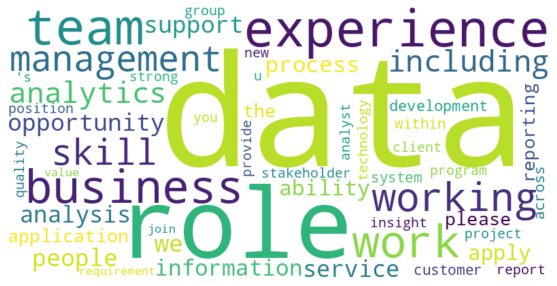

In [8]:
def nuage_de_mots(resultat,sauvegarde):
    # Créez un objet WordCloud
    nuage_de_mots = WordCloud(width=800, height=400, background_color='white',max_words=50)

    # Générez le nuage de mots à partir du dictionnaire
    nuage_de_mots.generate_from_frequencies(resultat)

    # Affichez le nuage de mots
    plt.figure(figsize=(10, 5))
    plt.imshow(nuage_de_mots, interpolation='bilinear')
    plt.axis('off')

    # Sauvegardez l'image
    plt.savefig(f"{sauvegarde}.jpeg")

    plt.show()

nuage_de_mots(resultat,"nuage_de_mots_description_lem")

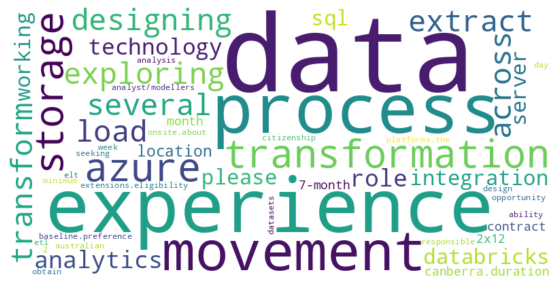

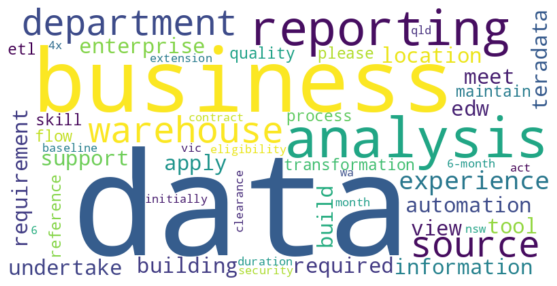

In [64]:
def nuage_de_mots_choix_ent_poste(df,entreprise,metier):
    # Créez un objet WordCloud
    
    nuage_de_mots = WordCloud(width=800, height=400, background_color='white',max_words=50)
    freq=df[(df['entreprise'] == entreprise) & (df['titre_lem_modified'] == metier)].description_compte
    # Générez le nuage de mots à partir du dictionnaire
    for i in list(freq.index):
        nuage_de_mots.generate_from_frequencies(freq.loc[i])
    #Affichez le nuage de mots

        plt.figure(figsize=(10, 5))
        plt.imshow(nuage_de_mots, interpolation='bilinear')
        plt.axis('off')

        # Sauvegardez l'image
        #plt.savefig(f"wordcloud_{entreprise}_{metier}_{i}.jpeg")
        
        plt.show()


nuage_de_mots_choix_ent_poste(df,"Ignite","data analyst")

Similarité de documents

In [56]:
st = stopwords.words('english')

vectorizer = TfidfVectorizer(lowercase=True, stop_words=st,
                            ngram_range=(1, 1),
                            use_idf=True, smooth_idf=True, 
                            sublinear_tf=False, norm='l2')

In [57]:
dtm = vectorizer.fit_transform(df.description_lem)

Nom des colonnes

In [58]:
vectorizer.get_feature_names_out()

array(['00', '000', '0001', ..., 'zero', 'zetland', 'zoo'], dtype=object)

In [59]:
sim_matrix = cosine_similarity(dtm, dtm)

In [60]:
query = ["""We are looking for someone who are passionate about Machine Learning, and have deep knowledge in Statistics and Computer Science. 
                      You enjoy doing data science projects with structured and/or unstructured data and are motivated to productize scalable machine learning models. 
                      We will also rely on you to build data products to extract valuable business insights. Critical thinking and problem-solving skills are essential for this role.
                      ualifications
                      BS (or higher, e.g., MS, or PhD) in Computer Science or related engineering field involving coding
                      Experienced implementing and scaling machine learning models in production environments
                      Strong understanding of machine learning theory
                      Hands on experience with Statistics
                      Capable of quickly implementing prototypes of cutting-edge research papers
                      Proficient in Python (i.e. Pandas, Numpy, scikit-learn, etc), R, TensorFlow, amongst other data science related tools and libraries
                      Analytical mind and strong business acumen"""]

In [61]:
query_vector = vectorizer.transform(query)
query_corpus_sim = cosine_similarity(query_vector, dtm)

In [62]:
idx_most_sim = np.argmax(query_corpus_sim)
df.loc[idx_most_sim]

titre                                                      Data Analyst
entreprise                                        PVS Australia Pty Ltd
lieu                                      Port Melbourne, Melbourne VIC
categorie             Business/Systems Analysts (Information & Commu...
contrat                                                       Full time
salaire                                                             NaN
parution                                                  Posted 1d ago
description           PVS Australia are a trusted operational adviso...
note                                                                NaN
review                                                              NaN
parution_modif                                                       1d
description_stem      pv australia trust oper advisor lead electron ...
description_lem       pvs australia trusted operational advisor lead...
titre_lem                                                  data 

## Classification docs

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Extraction de fonctionnalités (TF-IDF)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df.description_stem)

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X,df.titre_lem_modified , test_size=0.2, random_state=42)

# Entraînement du modèle
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Évaluation du modèle
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Précision du modèle :", accuracy)

# Prédiction



nouvelles_annonces = ["""We are looking for someone who are passionate about Machine Learning, and have deep knowledge in Statistics and Computer Science. 
                      You enjoy doing data science projects with structured and/or unstructured data and are motivated to productize scalable machine learning models. 
                      We will also rely on you to build data products to extract valuable business insights. Critical thinking and problem-solving skills are essential for this role.
                      ualifications
                      BS (or higher, e.g., MS, or PhD) in Computer Science or related engineering field involving coding
                      Experienced implementing and scaling machine learning models in production environments
                      Strong understanding of machine learning theory
                      Hands on experience with Statistics
                      Capable of quickly implementing prototypes of cutting-edge research papers
                      Proficient in Python (i.e. Pandas, Numpy, scikit-learn, etc), R, TensorFlow, amongst other data science related tools and libraries
                      Analytical mind and strong business acumen"""]
                      
nouvelles_annonces_vectorized = vectorizer.transform(nouvelles_annonces)
predictions = model.predict(nouvelles_annonces_vectorized)
print("Prédictions pour de nouvelles annonces de poste :", predictions)
#La ca marche pas trop c'est sensé être data scientist mais boon

Précision du modèle : 0.6774193548387096
Prédictions pour de nouvelles annonces de poste : ['data analyst']


Sauvegarde du nouveau jeu de données traité

In [ ]:
# Sauvegarde du nouveau jeu de données modifiés
date = datetime.today().strftime('%Y%m%d')
df.to_excel(f"{date}-Donnees_Info_Poste_Modif.xlsx", index=False)